## MagLev losses: calculations

### Test implementation, for 1 of the experiments.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

# Set the style
plt.style.use('https://github.com/kaiuki2000/PitayaRemix/raw/main/PitayaRemix.mplstyle')

df_FC_Long_1 = pd.read_csv('../Data/FC/FC_Long_1.csv', skiprows = 1, delimiter = ';')
print(f'Read {len(df_FC_Long_1)} rows.')

Read 1870 rows.


Plotting $x$'s results. These are corrected, so that they average $0$.

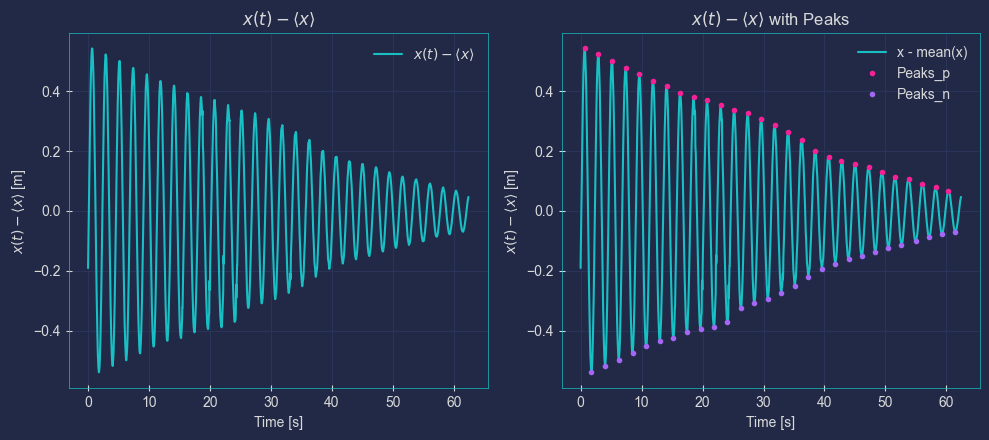

In [27]:
# Read the data
t = df_FC_Long_1['t']
x = df_FC_Long_1['x']
y = df_FC_Long_1['y']

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))

# Plot the first subplot
axs[0].plot(t, x - np.mean(x), label=r'$x(t) - \left<x\right>$')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel(r'$x(t) - \left<x\right>$ [m]')
axs[0].set_ylim(-max(x - np.mean(x)) - 0.05, max(x - np.mean(x)) + 0.05)
axs[0].set_title(r'$x(t) - \left<x\right>$')
axs[0].legend()

# Find the peaks
new_x = x - np.mean(x)
peaks_p, _ = find_peaks(new_x, distance=35, prominence=0.1)  # t[35] = 1.166 s. This is the minimum time between peaks.
peaks_n, _ = find_peaks(-new_x, distance=35, prominence=0.1)

# Plot the second subplot
axs[1].plot(t, new_x, label='x - mean(x)')
axs[1].plot(t[peaks_p], new_x[peaks_p], '.C1', label='Peaks_p')
axs[1].plot(t[peaks_n], new_x[peaks_n], '.C2', label='Peaks_n')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel(r'$x(t) - \left<x\right>$ [m]')
axs[1].set_ylim(-max(new_x) - 0.05, max(new_x) + 0.05)
axs[1].set_title(r'$x(t) - \left<x\right>$ with Peaks')
axs[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


Here, I transform the $x$ values back to $y$ values, and plot them. I do this because the $x$ values appear to be more stable. (The $y$ values showed some oscillations, probably due to the camera being tilted, relative to this axis - See sketch below.)

<img src="./Assets/y_problem_rotated.jpg" alt="Image Description" width="700px">


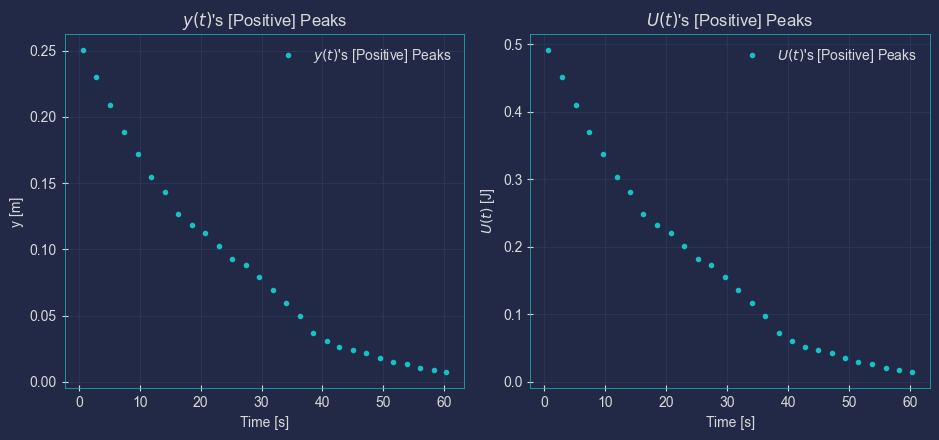

In [28]:
R = 0.802 # m # Change this value to the radius of the track
y_t =  [R - np.sqrt(R**2 - x**2) for x in x[peaks_p]]
t_t = t[peaks_p]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(9.5, 4.5))

# Plot the data with peaks on the first subplot
axs[0].plot(t_t, y_t, '.', label=r"$y(t)$'s [Positive] Peaks")
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('y [m]')
axs[0].set_title(r"$y(t)$'s [Positive] Peaks")
axs[0].legend()

# Pot. energy:
m = 0.2 # kg # Change this value to the mass of the object
g = 9.81 # m/s^2
U = [m * g * y for y in y_t]

# Plot the data with peaks on the second subplot
axs[1].plot(t_t, U, '.', label=r"$U(t)$'s [Positive] Peaks")
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel(r'$U(t)$ [J]')
axs[1].set_title(r"$U(t)$'s [Positive] Peaks")
axs[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

Automating things, for later:
- Putting everything into a class, for easier massification;
- Testing the class with the provided example.

In [29]:
class CsvAnalyzer:
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path, skiprows=1, delimiter=';')
        self.name = file_path.split('/')[-1]
        self.t = self.df['t']
        self.x = self.df['x']
        self.y = self.df['y']
        self.peaks_p = None
        self.U = None
        print(f'Read {len(self.df)} rows (from {file_path}).')

    def correct_x(self):
        self.x = self.df['x'] - np.mean(self.df['x'])

    def find_peaks(self, d = 35, p = 0.1):
        self.peaks_p, _ = find_peaks(-self.x, distance = d, prominence = p)
        print(f'Found {len(self.peaks_p)} [negative] peaks. (d = {d}, p = {p}).')
        
    def transform_to_y(self, R):
        self.y = [R - np.sqrt(R**2 - x**2) for x in self.x]

    def calculate_potential_energy(self, m, g):
        self.U = [m * g * y for y in np.array(self.y)[self.peaks_p]]

    def plot_potential_energy(self):
        plt.plot(self.t[self.peaks_p], self.U, '.', label=r"$U(t)$'s [negative] peaks")
        plt.xlabel('Time [s]')
        plt.ylabel(r'$U(t)$ [J]')
        plt.title(r"$U(t)$'s [negative] peaks for " + self.name)
        plt.legend()
        plt.show()

    def resolve(self, R, m, g, d, p, plot_flag = True):
        """
        Resolve the data and plot the potential energy.

        --- Parameters ---
        R: radius of the track [m]
        m: mass of the object [kg]
        g: gravity [m/s^2]
        d: minimum distance between peaks [s]
        p: minimum prominence of peaks [m]

        --- Returns ---
        None
        """
        self.correct_x()
        self.find_peaks(d, p)
        self.transform_to_y(R)
        self.calculate_potential_energy(m, g)
        if(plot_flag): self.plot_potential_energy()

        return self.t[self.peaks_p], self.U

Yeah, now I just need to run all the other experiments through Tracker, to obtain the $x, y, t$ data, so I can then use the class to calculate the losses. (And compare the results...)

In [30]:
# Required definitions/parameters:
R, m, g, d, p = 0.80, 0.2, 9.81, 35, 0.1

# Test the class
# Running on the other FC_Long files:
csv_analyzer_FC_Long_1 = CsvAnalyzer('../Data/FC/FC_Long_1.csv')
csv_analyzer_FC_Long_2 = CsvAnalyzer('../Data/FC/FC_Long_2.csv')
csv_analyzer_FC_Long_3 = CsvAnalyzer('../Data/FC/FC_Long_3.csv'); print()

FC_Long_1_t, FC_Long_1_U = csv_analyzer_FC_Long_1.resolve(R, m, g, d, p, plot_flag = False)
FC_Long_2_t, FC_Long_2_U = csv_analyzer_FC_Long_2.resolve(R, m, g, d, p, plot_flag = False)
FC_Long_3_t, FC_Long_3_U = csv_analyzer_FC_Long_3.resolve(R, m, g, d, p, plot_flag = False)

Read 1870 rows (from ../Data/FC/FC_Long_1.csv).
Read 1661 rows (from ../Data/FC/FC_Long_2.csv).
Read 471 rows (from ../Data/FC/FC_Long_3.csv).

Found 28 [negative] peaks. (d = 35, p = 0.1).
Found 21 [negative] peaks. (d = 35, p = 0.1).
Found 6 [negative] peaks. (d = 35, p = 0.1).


**I should also use the negative peaks!** (I'm only using the positive peaks, so far.)

**Update: 09/03**: I'm, actually, only using the negative peaks, now! This allows me to associate the $1^{st}$ with $1$ cycle having already elapsed. Each consecutive peak is then associated with the next cycle.

Now, I do the same for ZFC, for the same initial height, $h^-$.

In [31]:
# Reading the data into the class
csv_analyzer_ZFC_h_m_1 = CsvAnalyzer('../Data/ZFC/ZFC_h-_1.csv')
csv_analyzer_ZFC_h_m_2 = CsvAnalyzer('../Data/ZFC/ZFC_h-_2.csv')
csv_analyzer_ZFC_h_m_3 = CsvAnalyzer('../Data/ZFC/ZFC_h-_3.csv'); print()

# Resolving the data
ZFC_h_m_1_t, ZFC_h_m_1_U = csv_analyzer_ZFC_h_m_1.resolve(R, m, g, d, p, plot_flag = False)
ZFC_h_m_2_t, ZFC_h_m_2_U = csv_analyzer_ZFC_h_m_2.resolve(R, m, g, d, p, plot_flag = False)
ZFC_h_m_3_t, ZFC_h_m_3_U = csv_analyzer_ZFC_h_m_3.resolve(R, m, g, d, p, plot_flag = False)

Read 3098 rows (from ../Data/ZFC/ZFC_h-_1.csv).
Read 3090 rows (from ../Data/ZFC/ZFC_h-_2.csv).
Read 2360 rows (from ../Data/ZFC/ZFC_h-_3.csv).

Found 45 [negative] peaks. (d = 35, p = 0.1).
Found 46 [negative] peaks. (d = 35, p = 0.1).
Found 35 [negative] peaks. (d = 35, p = 0.1).


Now, same for a greater initial height, $h^+$: (I'm still missing these!)

In [ ]:
# Reading the data into the class
csv_analyzer_ZFC_h_p_1 = CsvAnalyzer('../Data/ZFC/ZFC_h+_1.csv')
csv_analyzer_ZFC_h_p_2 = CsvAnalyzer('../Data/ZFC/ZFC_h+_2.csv')
csv_analyzer_ZFC_h_p_3 = CsvAnalyzer('../Data/ZFC/ZFC_h+_3.csv'); print()

# Resolving the data
ZFC_h_p_1_t, ZFC_h_p_1_U = csv_analyzer_ZFC_h_p_1.resolve(R, m, g, d, p)
ZFC_h_p_2_t, ZFC_h_p_2_U = csv_analyzer_ZFC_h_p_2.resolve(R, m, g, d, p)
ZFC_h_p_3_t, ZFC_h_p_3_U = csv_analyzer_ZFC_h_p_3.resolve(R, m, g, d, p)

I can now compare all the results...

Other things to do:
- Tracker;
- Average the plots, for each height value (This will require that I go from time on the $x$ axis to $\#$ Cycles, and then average the values for each $\#$ Cycles value.);
- Also, put the FC and ZFC results together, for each height value, and compare them. (<span style="color:red">**✓**</span>)

### Comparison section:

All the $U(t)$ plots (so far):

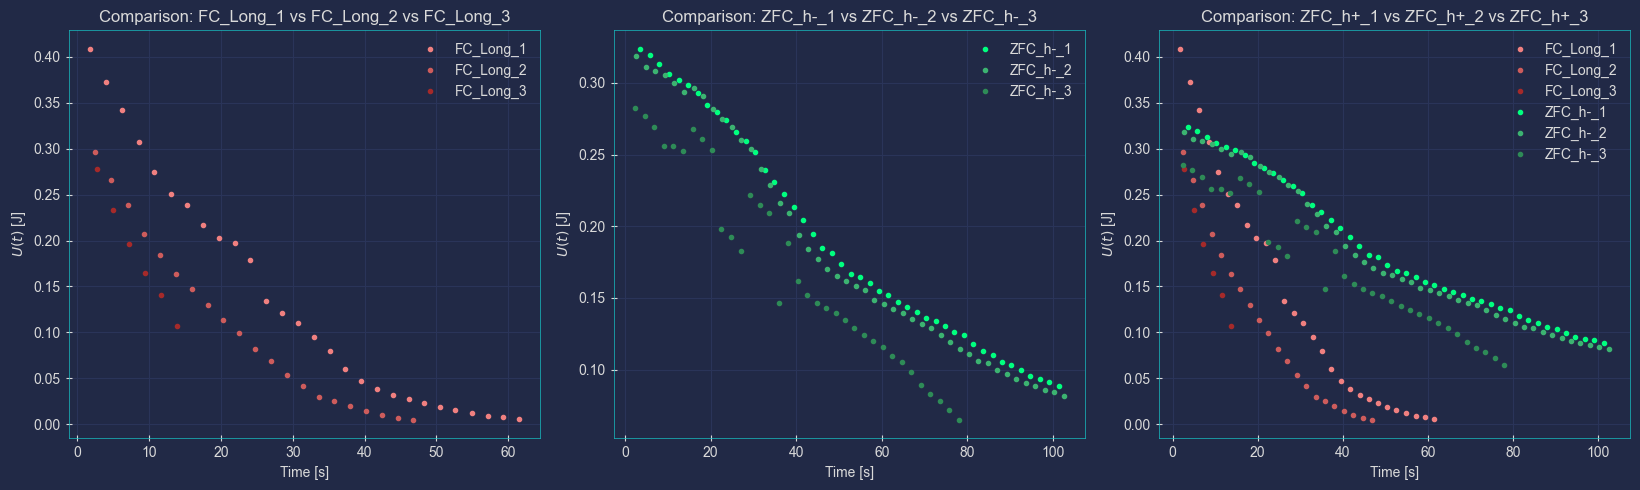

In [111]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(16.5, 5))

# Plot the data for FC_Long_1 and ZFC_h-_1 on the first subplot
axs[0].plot(FC_Long_1_t, FC_Long_1_U, '.',  color = 'lightcoral', label='FC_Long_1')
axs[0].plot(FC_Long_2_t, FC_Long_2_U, '.',  color = 'indianred',  label='FC_Long_2')
axs[0].plot(FC_Long_3_t, FC_Long_3_U, '.',  color = 'brown',      label='FC_Long_3')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel(r'$U(t)$ [J]')
axs[0].set_title('Comparison: FC_Long_1 vs FC_Long_2 vs FC_Long_3')
axs[0].legend()

# Plot the data for ZFC_h-_1 and ZFC_h-_2 on the second subplot
axs[1].plot(ZFC_h_m_1_t, ZFC_h_m_1_U, '.',  color = 'springgreen',       label='ZFC_h-_1')
axs[1].plot(ZFC_h_m_2_t, ZFC_h_m_2_U, '.',  color = 'mediumseagreen', label='ZFC_h-_2')
axs[1].plot(ZFC_h_m_3_t, ZFC_h_m_3_U, '.',  color = 'seagreen',    label='ZFC_h-_3')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel(r'$U(t)$ [J]')
axs[1].set_title('Comparison: ZFC_h-_1 vs ZFC_h-_2 vs ZFC_h-_3')
axs[1].legend()

# Plot the data for ZFC_h+_1, ZFC_h+_2, and ZFC_h+_3 on the third subplot
axs[2].plot(FC_Long_1_t, FC_Long_1_U, '.', color = 'lightcoral',     label='FC_Long_1')
axs[2].plot(FC_Long_2_t, FC_Long_2_U, '.', color = 'indianred',      label='FC_Long_2')
axs[2].plot(FC_Long_3_t, FC_Long_3_U, '.', color = 'brown',          label='FC_Long_3')
axs[2].plot(ZFC_h_m_1_t, ZFC_h_m_1_U, '.', color = 'springgreen',       label='ZFC_h-_1')
axs[2].plot(ZFC_h_m_2_t, ZFC_h_m_2_U, '.', color = 'mediumseagreen', label='ZFC_h-_2')
axs[2].plot(ZFC_h_m_3_t, ZFC_h_m_3_U, '.', color = 'seagreen',    label='ZFC_h-_3')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel(r'$U(t)$ [J]')
axs[2].set_title('Comparison: ZFC_h+_1 vs ZFC_h+_2 vs ZFC_h+_3')
axs[2].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


Naïve comparisons:

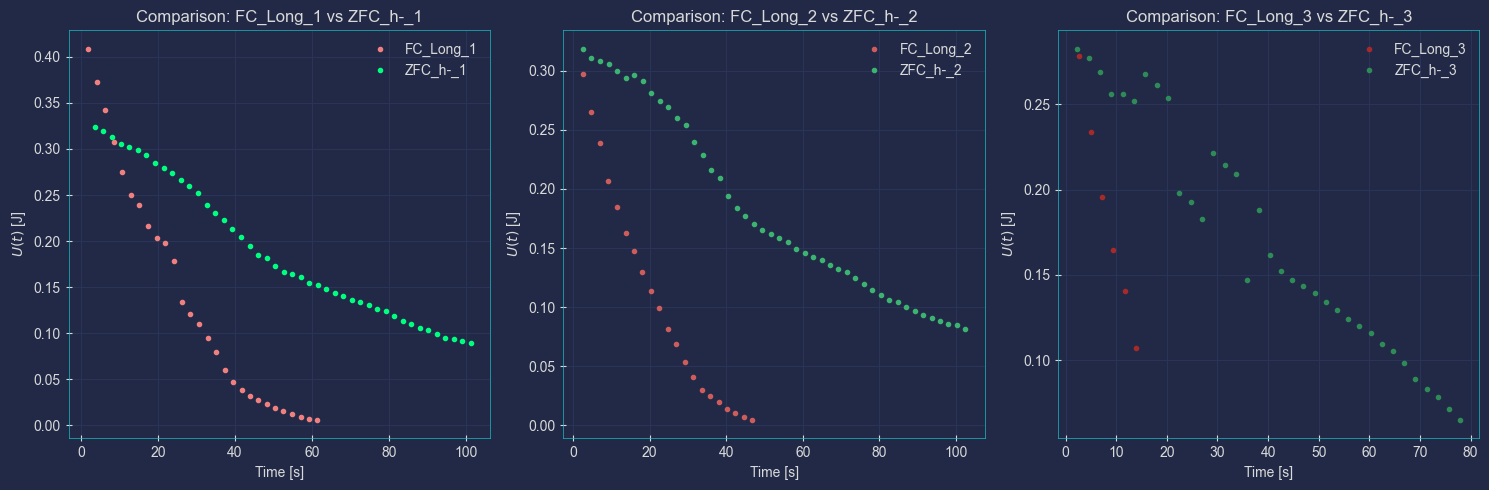

In [112]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the data for FC_Long_1 and ZFC_h-_1 on the first subplot
axs[0].plot(FC_Long_1_t, FC_Long_1_U, '.', color = 'lightcoral', label='FC_Long_1')
axs[0].plot(ZFC_h_m_1_t, ZFC_h_m_1_U, '.', color = 'springgreen', label='ZFC_h-_1')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel(r'$U(t)$ [J]')
axs[0].set_title('Comparison: FC_Long_1 vs ZFC_h-_1')
axs[0].legend()

# Plot the data for FC_Long_2 and ZFC_h-_2 on the second subplot
axs[1].plot(FC_Long_2_t, FC_Long_2_U, '.', color = 'indianred', label='FC_Long_2')
axs[1].plot(ZFC_h_m_2_t, ZFC_h_m_2_U, '.', color = 'mediumseagreen', label='ZFC_h-_2')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel(r'$U(t)$ [J]')
axs[1].set_title('Comparison: FC_Long_2 vs ZFC_h-_2')
axs[1].legend()

# Plot the data for FC_Long_3 and ZFC_h-_3 on the third subplot
axs[2].plot(FC_Long_3_t, FC_Long_3_U, '.', color = 'brown', label='FC_Long_3')
axs[2].plot(ZFC_h_m_3_t, ZFC_h_m_3_U, '.', color = 'seagreen', label='ZFC_h-_3')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel(r'$U(t)$ [J]')
axs[2].set_title('Comparison: FC_Long_3 vs ZFC_h-_3')
axs[2].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


### Transformation from $t$ (time) to $\#$ Cycles (and averaging!):
These are, probably, the most relevant graphs to compare!

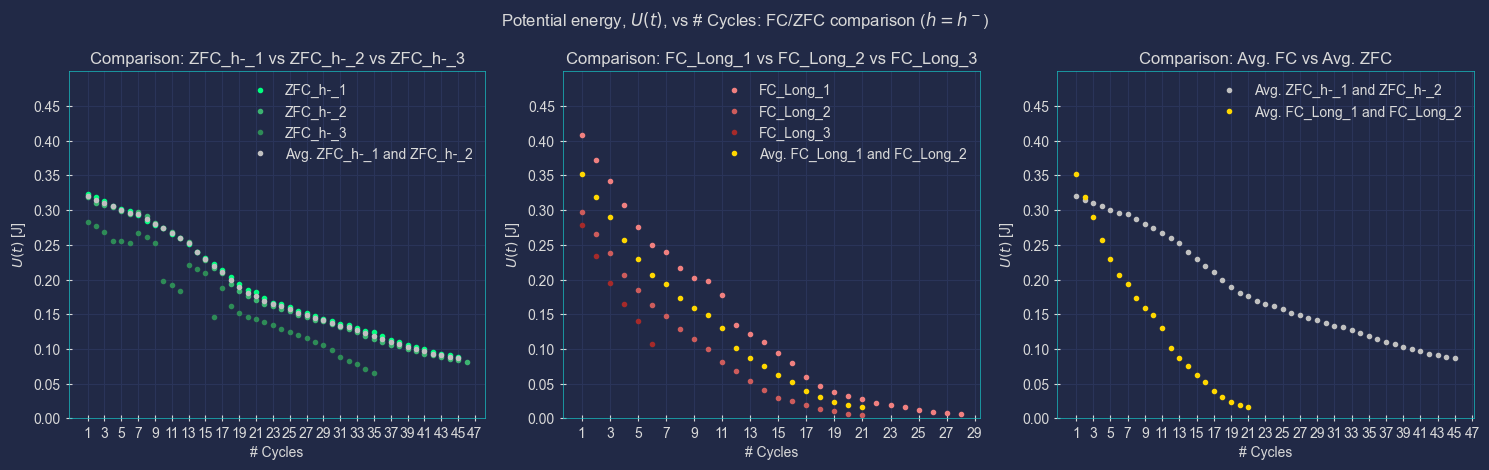

In [149]:
# Here, I only use ZFC_h_m_1_U and ZFC_h_m_2_U to compute the average, as ZFC_h_m_3_U appears to have a lot more noise.
l_min = min(len(ZFC_h_m_1_U), len(ZFC_h_m_2_U))
l_max = max(len(ZFC_h_m_1_U), len(ZFC_h_m_2_U), len(ZFC_h_m_3_U))

l_min_2 = min(len(FC_Long_1_U), len(FC_Long_2_U))
l_max_2 = max(len(FC_Long_1_U), len(FC_Long_2_U), len(FC_Long_3_U))

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4.75))



########## First subplot: Start ########## ########## First subplot: Start ##########
# Plot the data for ZFC_h-_1, ZFC_h-_2, and the average of ZFC_h-_1 and ZFC_h-_2 on the first subplot
axs[0].plot(range(1, len(ZFC_h_m_1_U) + 1), ZFC_h_m_1_U, '.', color='springgreen', label='ZFC_h-_1')
axs[0].plot(range(1, len(ZFC_h_m_2_U) + 1), ZFC_h_m_2_U, '.', color='mediumseagreen', label='ZFC_h-_2')
axs[0].plot(range(1, len(ZFC_h_m_3_U) + 1), ZFC_h_m_3_U, '.', color='seagreen', label='ZFC_h-_3')

# Plotting the average of ZFC_h_m_1_U and ZFC_h_m_2_U
axs[0].plot(range(1, l_min + 1), np.mean([ZFC_h_m_1_U[:l_min], ZFC_h_m_2_U[:l_min]], axis=0), '.', color='silver', label='Avg. ZFC_h-_1 and ZFC_h-_2')

# Set x-axis ticks at every 2 units
axs[0].set_xticks(range(1, l_max + 1 + 1, 2))

# Set y-axis ticks at every 0.5 units
axs[0].set_yticks(np.arange(0, 0.5, 0.05))
axs[0].set_ylim(0, 0.5)

axs[0].set_xlabel('# Cycles')
axs[0].set_ylabel(r'$U(t)$ [J]')
axs[0].set_title('Comparison: ZFC_h-_1 vs ZFC_h-_2 vs ZFC_h-_3')
axs[0].legend()
########## First subplot: End ########## ########## First subplot: End ##########



########## Second subplot: Start ########## ########## Second subplot: Start ##########
# Plot the data for FC_Long_1, FC_Long_2, and FC_Long_3 on the second subplot
axs[1].plot(range(1, len(FC_Long_1_U) + 1), FC_Long_1_U, '.', color='lightcoral', label='FC_Long_1')
axs[1].plot(range(1, len(FC_Long_2_U) + 1), FC_Long_2_U, '.', color='indianred', label='FC_Long_2')
axs[1].plot(range(1, len(FC_Long_3_U) + 1), FC_Long_3_U, '.', color='brown', label='FC_Long_3')

# Plotting the average of FC_Long_1_U, FC_Long_2_U, and FC_Long_3_U
axs[1].plot(range(1, l_min_2 + 1), np.mean([FC_Long_1_U[:l_min_2], FC_Long_2_U[:l_min_2]], axis=0), '.', color='gold', label='Avg. FC_Long_1 and FC_Long_2')

# Set x-axis ticks at every 2 units
axs[1].set_xticks(range(1, l_max_2 + 1 + 1, 2))

# Set y-axis ticks at every 0.5 units
axs[1].set_yticks(np.arange(0, 0.5, 0.05))
axs[1].set_ylim(0, 0.5)

axs[1].set_xlabel('# Cycles')
axs[1].set_ylabel(r'$U(t)$ [J]')
axs[1].set_title('Comparison: FC_Long_1 vs FC_Long_2 vs FC_Long_3')
axs[1].legend()
########## Second subplot: End ########## ########## Second subplot: End ##########



########## Third subplot:
#  Start ########## ########## Third subplot: Start ##########
# Plotting the average of FC_Long_1_U, FC_Long_2_U, and FC_Long_3_U
axs[2].plot(range(1, l_min + 1), np.mean([ZFC_h_m_1_U[:l_min], ZFC_h_m_2_U[:l_min]], axis=0), '.', color='silver', label='Avg. ZFC_h-_1 and ZFC_h-_2')
axs[2].plot(range(1, l_min_2 + 1), np.mean([FC_Long_1_U[:l_min_2], FC_Long_2_U[:l_min_2]], axis=0), '.', color='gold', label='Avg. FC_Long_1 and FC_Long_2')

# Set x-axis ticks at every 2 units
axs[2].set_xticks(range(1, max(l_max, l_max_2) + 1 + 1, 2))

# Set y-axis ticks at every 0.5 units
axs[2].set_yticks(np.arange(0, 0.5, 0.05))
axs[2].set_ylim(0, 0.5)

axs[2].set_xlabel('# Cycles')
axs[2].set_ylabel(r'$U(t)$ [J]')
axs[2].set_title(r'Comparison: Avg. FC vs Avg. ZFC')
axs[2].legend()
########## Third subplot: End ########## ########## Third subplot: End ##########


plt.suptitle(r'Potential energy, $U(t)$, vs # Cycles: FC/ZFC comparison ($h = h^-$)')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# Save the figure
fig.savefig('./Plots/Comparison_FC_vs_ZFC.png', dpi=300, bbox_inches='tight')

### Section with all the plots, for visualization:

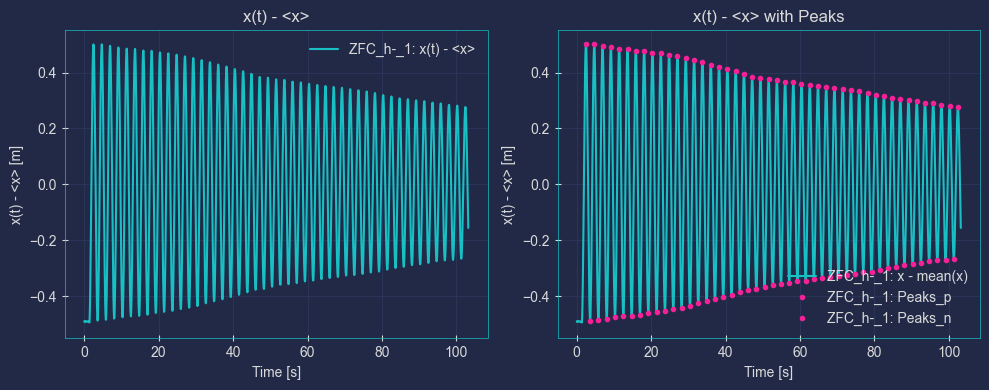

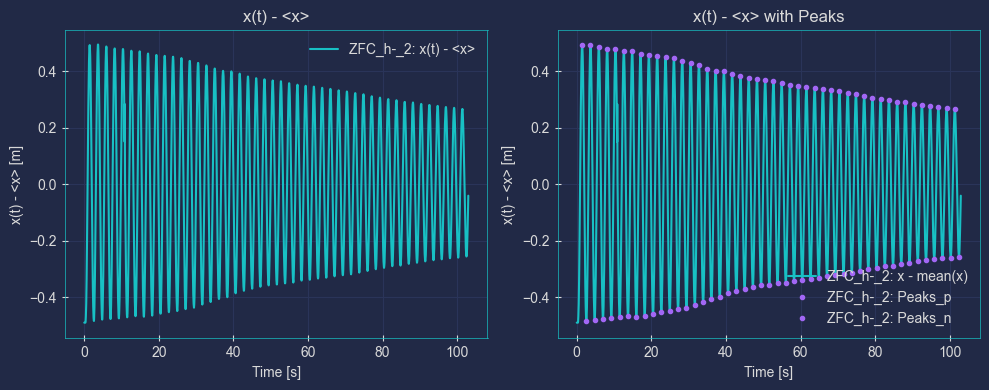

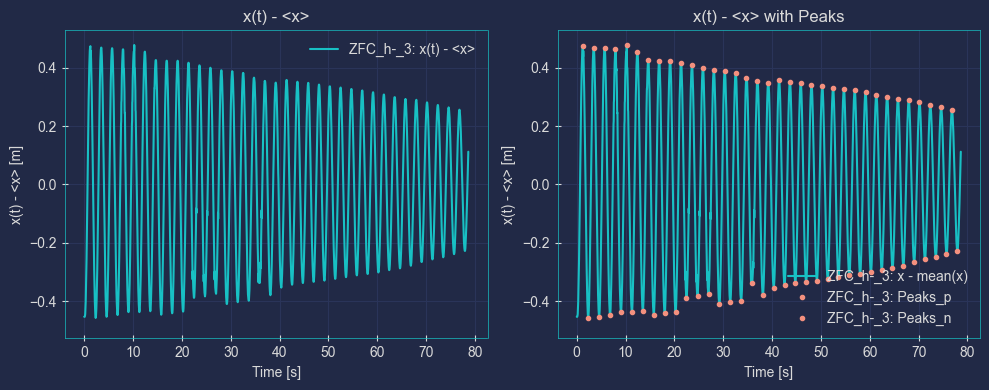

In [99]:
df_ZFC_h_m_1 = pd.read_csv('../Data/ZFC/ZFC_h-_1.csv', skiprows = 1, delimiter = ';')
df_ZFC_h_m_2 = pd.read_csv('../Data/ZFC/ZFC_h-_2.csv', skiprows = 1, delimiter = ';')
df_ZFC_h_m_3 = pd.read_csv('../Data/ZFC/ZFC_h-_3.csv', skiprows = 1, delimiter = ';')

# Iterate over the dataframes
for i, df in enumerate([df_ZFC_h_m_1, df_ZFC_h_m_2, df_ZFC_h_m_3]):

    # Create the figures and subplots
    fig1, axs1 = plt.subplots(1, 2, figsize=(10, 4))

    # Read the data
    t = df['t']
    x = df['x']
    y = df['y']

    # Find the peaks
    new_x = x - np.mean(x)
    peaks_p, _ = find_peaks(new_x, distance=35, prominence=0.1)  # t[35] = 1.166 s. This is the minimum time between peaks.
    peaks_n, _ = find_peaks(-new_x, distance=35, prominence=0.1)

    # Plot the first subplot of the first figure
    axs1[0].plot(t, x - np.mean(x), label=f'ZFC_h-_{i+1}: x(t) - <x>')
    axs1[0].set_xlabel('Time [s]')
    axs1[0].set_ylabel('x(t) - <x> [m]')
    axs1[0].set_ylim(-max(x - np.mean(x)) - 0.05, max(x - np.mean(x)) + 0.05)
    axs1[0].set_title('x(t) - <x>')
    axs1[0].legend()

    # Plot the second subplot of the first figure
    axs1[1].plot(t, new_x, label=f'ZFC_h-_{i+1}: x - mean(x)')
    axs1[1].plot(t[peaks_p], new_x[peaks_p], f'.C{i+1}', label=f'ZFC_h-_{i+1}: Peaks_p')
    axs1[1].plot(t[peaks_n], new_x[peaks_n], f'.C{i+1}', label=f'ZFC_h-_{i+1}: Peaks_n')
    axs1[1].set_xlabel('Time [s]')
    axs1[1].set_ylabel('x(t) - <x> [m]')
    axs1[1].set_ylim(-max(new_x) - 0.05, max(new_x) + 0.05)
    axs1[1].set_title('x(t) - <x> with Peaks')
    axs1[1].legend()

    fig1.tight_layout()
    
    # Show the figures
    plt.show(fig1)


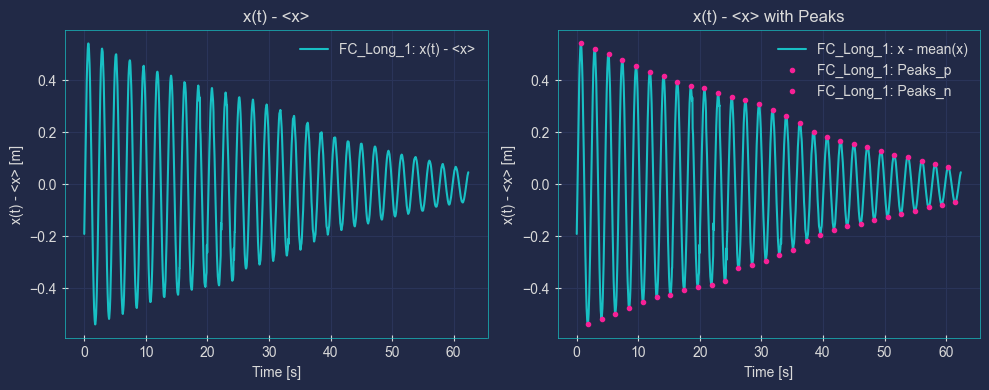

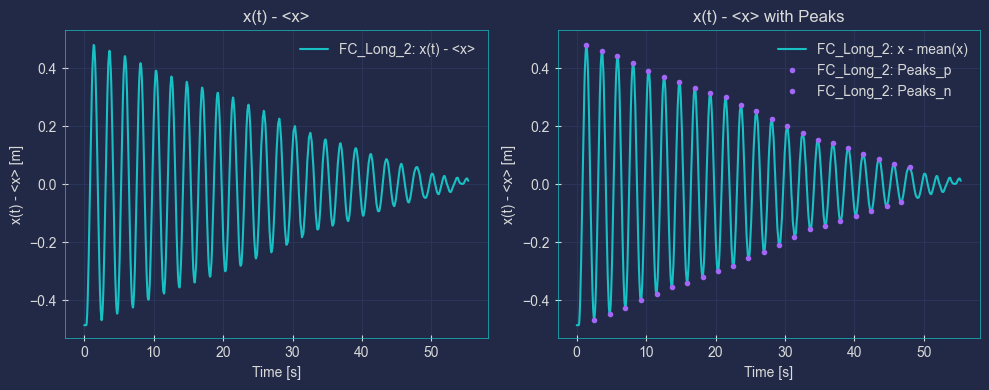

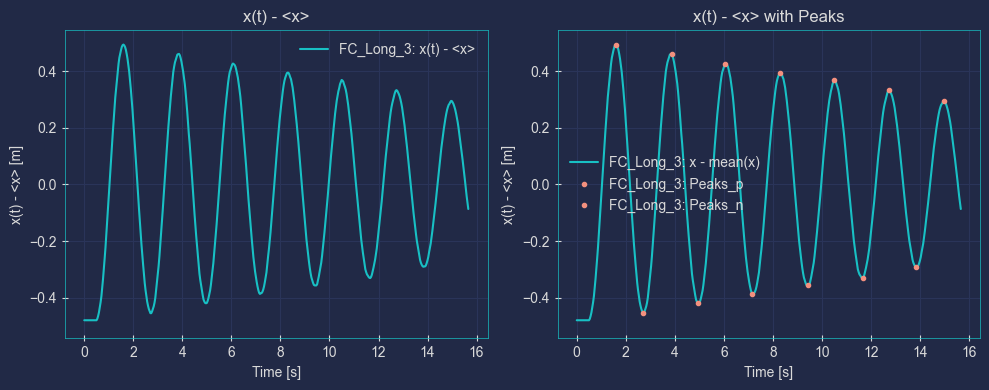

In [50]:
df_FC_Long_1 = pd.read_csv('../Data/FC/FC_Long_1.csv', skiprows = 1, delimiter = ';')
df_FC_Long_2 = pd.read_csv('../Data/FC/FC_Long_2.csv', skiprows = 1, delimiter = ';')
df_FC_Long_3 = pd.read_csv('../Data/FC/FC_Long_3.csv', skiprows = 1, delimiter = ';')

# Iterate over the dataframes
for i, df in enumerate([df_FC_Long_1, df_FC_Long_2, df_FC_Long_3]):

    # Create the figures and subplots
    fig1, axs1 = plt.subplots(1, 2, figsize=(10, 4))

    # Read the data
    t = df['t']
    x = df['x']
    y = df['y']

    # Find the peaks
    new_x = x - np.mean(x)
    peaks_p, _ = find_peaks(new_x, distance=35, prominence=0.1)  # t[35] = 1.166 s. This is the minimum time between peaks.
    peaks_n, _ = find_peaks(-new_x, distance=35, prominence=0.1)

    # Plot the first subplot of the first figure
    axs1[0].plot(t, x - np.mean(x), label=f'FC_Long_{i+1}: x(t) - <x>')
    axs1[0].set_xlabel('Time [s]')
    axs1[0].set_ylabel('x(t) - <x> [m]')
    axs1[0].set_ylim(-max(x - np.mean(x)) - 0.05, max(x - np.mean(x)) + 0.05)
    axs1[0].set_title('x(t) - <x>')
    axs1[0].legend()

    # Plot the second subplot of the first figure
    axs1[1].plot(t, new_x, label=f'FC_Long_{i+1}: x - mean(x)')
    axs1[1].plot(t[peaks_p], new_x[peaks_p], f'.C{i+1}', label=f'FC_Long_{i+1}: Peaks_p')
    axs1[1].plot(t[peaks_n], new_x[peaks_n], f'.C{i+1}', label=f'FC_Long_{i+1}: Peaks_n')
    axs1[1].set_xlabel('Time [s]')
    axs1[1].set_ylabel('x(t) - <x> [m]')
    axs1[1].set_ylim(-max(new_x) - 0.05, max(new_x) + 0.05)
    axs1[1].set_title('x(t) - <x> with Peaks')
    axs1[1].legend()

    fig1.tight_layout()
    
    # Show the figures
    plt.show(fig1)


This is where we see that the first negative peak corresponds to $1$ cycle having already elapsed. (This is the case for all the experiments.)

### Aerodynamic losses:

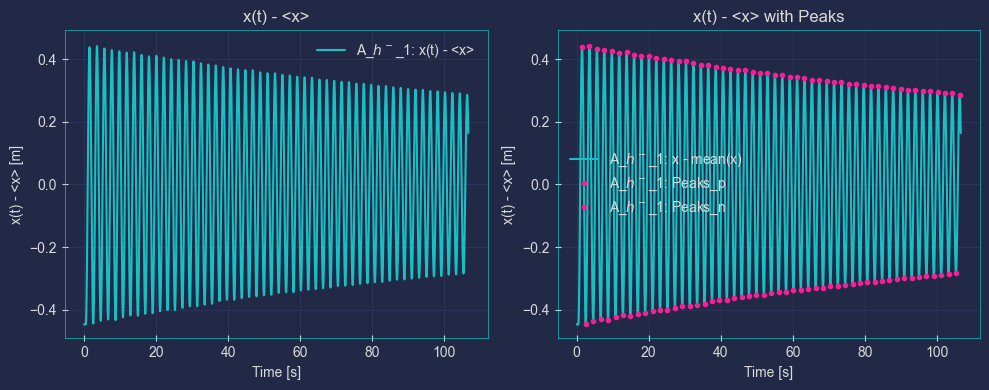

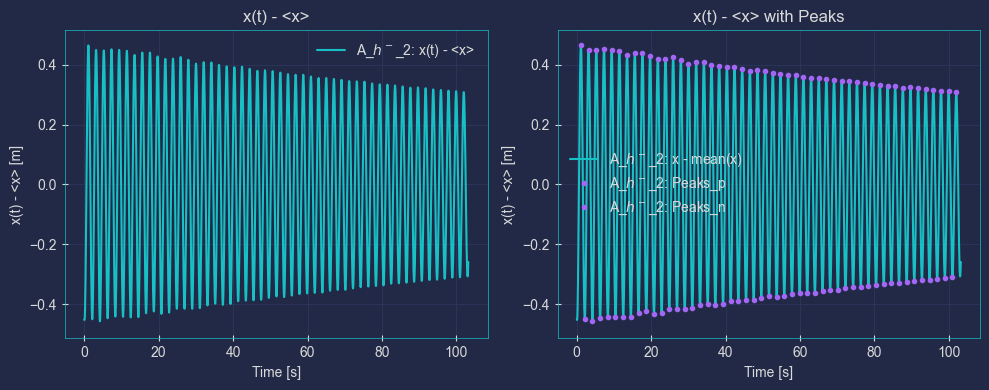

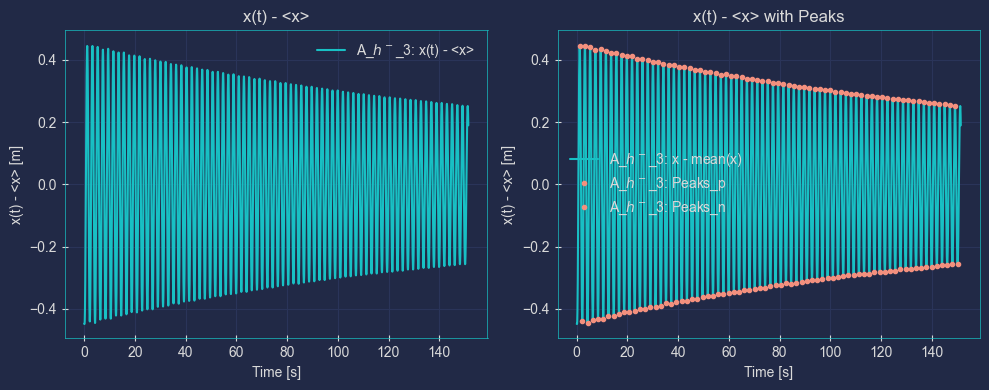

In [7]:
df_A_h_m_1 = pd.read_csv('../Data/Aerodynamics/h-/A_h-_1.csv', skiprows = 1, delimiter = ';')
df_A_h_m_2 = pd.read_csv('../Data/Aerodynamics/h-/A_h-_2.csv', skiprows = 1, delimiter = ';')
df_A_h_m_4 = pd.read_csv('../Data/Aerodynamics/h-/A_h-_4.csv', skiprows = 1, delimiter = ';')

# Iterate over the dataframes
for i, df in enumerate([df_A_h_m_1, df_A_h_m_2, df_A_h_m_4]):

    # Create the figures and subplots
    fig1, axs1 = plt.subplots(1, 2, figsize=(10, 4))

    # Read the data
    t = df['t']
    x = df['x']
    y = df['y']

    # Find the peaks
    new_x = x - np.mean(x)
    peaks_p, _ = find_peaks(new_x, distance=35, prominence=0.1)  # t[35] = 1.166 s. This is the minimum time between peaks.
    peaks_n, _ = find_peaks(-new_x, distance=35, prominence=0.1)

    # Plot the first subplot of the first figure
    axs1[0].plot(t, x - np.mean(x), label=f'A_$h^-$_{i+1}: x(t) - <x>')
    axs1[0].set_xlabel('Time [s]')
    axs1[0].set_ylabel('x(t) - <x> [m]')
    axs1[0].set_ylim(-max(x - np.mean(x)) - 0.05, max(x - np.mean(x)) + 0.05)
    axs1[0].set_title('x(t) - <x>')
    axs1[0].legend()

    # Plot the second subplot of the first figure
    axs1[1].plot(t, new_x, label=f'A_$h^-$_{i+1}: x - mean(x)')
    axs1[1].plot(t[peaks_p], new_x[peaks_p], f'.C{i+1}', label=rf'A_$h^-$_{i+1}: Peaks_p')
    axs1[1].plot(t[peaks_n], new_x[peaks_n], f'.C{i+1}', label=rf'A_$h^-$_{i+1}: Peaks_n')
    axs1[1].set_xlabel('Time [s]')
    axs1[1].set_ylabel('x(t) - <x> [m]')
    axs1[1].set_ylim(-max(new_x) - 0.05, max(new_x) + 0.05)
    axs1[1].set_title('x(t) - <x> with Peaks')
    axs1[1].legend()

    fig1.tight_layout()
    
    # Show the figures
    plt.show(fig1)


In [9]:
# Reading the data into the class
csv_analyzer_A_h_m_1 = CsvAnalyzer('../Data/Aerodynamics/h-/A_h-_1.csv')
csv_analyzer_A_h_m_2 = CsvAnalyzer('../Data/Aerodynamics/h-/A_h-_2.csv')
csv_analyzer_A_h_m_4 = CsvAnalyzer('../Data/Aerodynamics/h-/A_h-_4.csv'); print()

# Resolving the data
A_h_m_1_t, A_h_m_1_U = csv_analyzer_A_h_m_1.resolve(R, m, g, d, p, plot_flag = False)
A_h_m_2_t, A_h_m_2_U = csv_analyzer_A_h_m_2.resolve(R, m, g, d, p, plot_flag = False)
A_h_m_4_t, A_h_m_4_U = csv_analyzer_A_h_m_4.resolve(R, m, g, d, p, plot_flag = False)

Read 6402 rows (from ../Data/Aerodynamics/h-/A_h-_1.csv).
Read 6195 rows (from ../Data/Aerodynamics/h-/A_h-_2.csv).
Read 9091 rows (from ../Data/Aerodynamics/h-/A_h-_4.csv).

Found 51 [negative] peaks. (d = 35, p = 0.1).
Found 49 [negative] peaks. (d = 35, p = 0.1).
Found 73 [negative] peaks. (d = 35, p = 0.1).


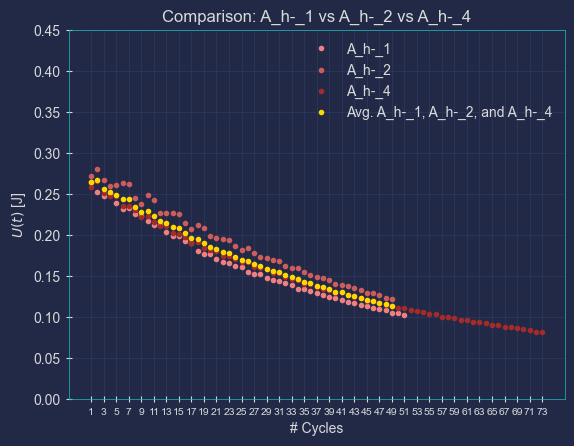

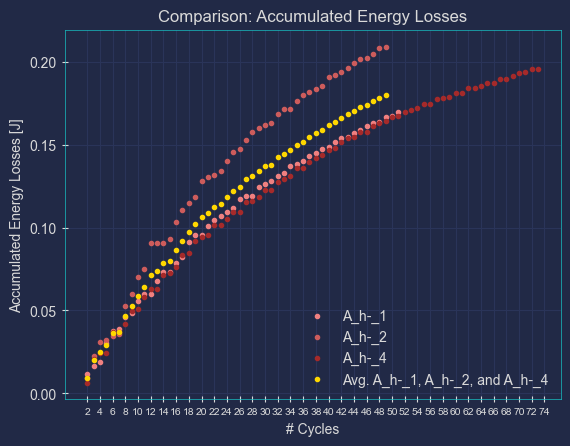

In [65]:
# Averaging process:
l_min = min(len(A_h_m_1_U), len(A_h_m_2_U), len(A_h_m_4_U))
l_max = max(len(A_h_m_1_U), len(A_h_m_2_U), len(A_h_m_4_U))

plt.plot(range(1, len(A_h_m_1_U) + 1), A_h_m_1_U, '.', color='lightcoral', label='A_h-_1')
plt.plot(range(1, len(A_h_m_2_U) + 1), A_h_m_2_U, '.', color='indianred', label='A_h-_2')
plt.plot(range(1, len(A_h_m_4_U) + 1), A_h_m_4_U, '.', color='brown', label='A_h-_4')

# Plotting the average of A_h_m_1_U, A_h_m_2_U, and A_h_m_4_U
plt.plot(range(1, l_min + 1), np.mean([A_h_m_1_U[:l_min], A_h_m_2_U[:l_min], A_h_m_4_U[:l_min]], axis=0), '.', color='gold', label='Avg. A_h-_1, A_h-_2, and A_h-_4')

# Set x-axis ticks at every 2 units
plt.xticks(range(1, l_max + 1 + 1, 2), fontsize=7.5)

# Set y-axis ticks at every 0.5 units
plt.yticks(np.arange(0, 0.5, 0.05))

plt.xlabel('# Cycles')
plt.ylabel(r'$U(t)$ [J]')
plt.title('Comparison: A_h-_1 vs A_h-_2 vs A_h-_4')
plt.legend()

# Show the figure
plt.show()

########## Accumulated energy losses ########## ########## Accumulated energy losses ##########
# Averaging process:
l_min = min(len(A_h_m_1_U), len(A_h_m_2_U), len(A_h_m_4_U)) - 1
l_max = max(len(A_h_m_1_U), len(A_h_m_2_U), len(A_h_m_4_U)) - 1

# Accumulated energy losses
A_h_m_1_U_loss = np.cumsum(np.abs(np.diff(A_h_m_1_U)))
A_h_m_2_U_loss = np.cumsum(np.abs(np.diff(A_h_m_2_U)))
A_h_m_4_U_loss = np.cumsum(np.abs(np.diff(A_h_m_4_U)))

# Plotting the data
plt.plot(range(2, len(A_h_m_1_U_loss) + 2), A_h_m_1_U_loss, '.', color='lightcoral', label='A_h-_1')
plt.plot(range(2, len(A_h_m_2_U_loss) + 2), A_h_m_2_U_loss, '.', color='indianred', label='A_h-_2')
plt.plot(range(2, len(A_h_m_4_U_loss) + 2), A_h_m_4_U_loss, '.', color='brown', label='A_h-_4')

# Plotting the average of A_h_m_1_U_loss, A_h_m_2_U_loss, and A_h_m_4_U_loss
plt.plot(range(2, l_min + 2), np.mean([A_h_m_1_U_loss[:l_min], A_h_m_2_U_loss[:l_min], A_h_m_4_U_loss[:l_min]], axis=0), '.', color='gold', label='Avg. A_h-_1, A_h-_2, and A_h-_4')

# Set x-axis ticks at every 2 units
plt.xticks(range(2, l_max + 2 + 1, 2), fontsize=7.5)

# Set y-axis ticks at every 0.5 units
plt.yticks(np.arange(0, 0.25, 0.05))

plt.xlabel('# Cycles')
plt.ylabel('Accumulated Energy Losses [J]')
plt.title('Comparison: Accumulated Energy Losses')
plt.legend()

# Show the figure
plt.show()
########## Accumulated energy losses ########## ########## Accumulated energy losses ##########

Accumulated energy losses, for each experiment:

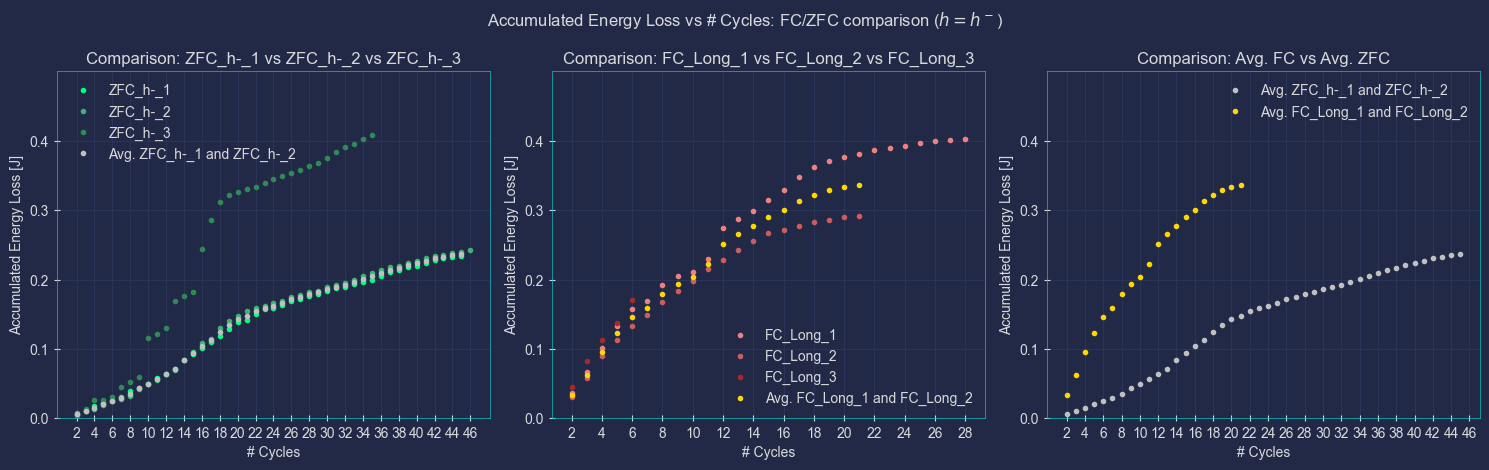

In [76]:
# Here, I only use ZFC_h_m_1_U and ZFC_h_m_2_U to compute the average, as ZFC_h_m_3_U appears to have a lot more noise.
l_min = min(len(ZFC_h_m_1_U), len(ZFC_h_m_2_U)) - 1
l_max = max(len(ZFC_h_m_1_U), len(ZFC_h_m_2_U), len(ZFC_h_m_3_U)) - 1

l_min_2 = min(len(FC_Long_1_U), len(FC_Long_2_U)) - 1
l_max_2 = max(len(FC_Long_1_U), len(FC_Long_2_U), len(FC_Long_3_U)) - 1

# Compute the accumulated energy loss
ZFC_h_m_1_loss = np.cumsum(np.abs(np.diff(ZFC_h_m_1_U)))
ZFC_h_m_2_loss = np.cumsum(np.abs(np.diff(ZFC_h_m_2_U)))
ZFC_h_m_3_loss = np.cumsum(np.abs(np.diff(ZFC_h_m_3_U)))

FC_Long_1_loss = np.cumsum(np.abs(np.diff(FC_Long_1_U)))
FC_Long_2_loss = np.cumsum(np.abs(np.diff(FC_Long_2_U)))
FC_Long_3_loss = np.cumsum(np.abs(np.diff(FC_Long_3_U)))

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4.75))

########## First subplot: Start ########## ########## First subplot: Start ##########
# Plot the accumulated energy loss for ZFC_h-_1, ZFC_h-_2, and ZFC_h-_3 on the first subplot
axs[0].plot(range(2, len(ZFC_h_m_1_loss) + 2), ZFC_h_m_1_loss, '.', color='springgreen', label='ZFC_h-_1')
axs[0].plot(range(2, len(ZFC_h_m_2_loss) + 2), ZFC_h_m_2_loss, '.', color='mediumseagreen', label='ZFC_h-_2')
axs[0].plot(range(2, len(ZFC_h_m_3_loss) + 2), ZFC_h_m_3_loss, '.', color='seagreen', label='ZFC_h-_3')

# Plotting the average of ZFC_h_m_1_loss and ZFC_h_m_2_loss
axs[0].plot(range(2, l_min + 2), np.mean([ZFC_h_m_1_loss[:l_min], ZFC_h_m_2_loss[:l_min]], axis=0), '.', color='silver', label='Avg. ZFC_h-_1 and ZFC_h-_2')

# Set x-axis ticks at every 2 units
axs[0].set_xticks(range(2, l_max + 2 + 1, 2))

# Set y-axis ticks at every 0.1 units
axs[0].set_yticks(np.arange(0, 0.5, 0.1))
axs[0].set_ylim(0, 0.5)

axs[0].set_xlabel('# Cycles')
axs[0].set_ylabel('Accumulated Energy Loss [J]')
axs[0].set_title('Comparison: ZFC_h-_1 vs ZFC_h-_2 vs ZFC_h-_3')
axs[0].legend()
########## First subplot: End ########## ########## First subplot: End ##########

########## Second subplot: Start ########## ########## Second subplot: Start ##########
# Plot the accumulated energy loss for FC_Long_1, FC_Long_2, and FC_Long_3 on the second subplot
axs[1].plot(range(2, len(FC_Long_1_loss) + 2), FC_Long_1_loss, '.', color='lightcoral', label='FC_Long_1')
axs[1].plot(range(2, len(FC_Long_2_loss) + 2), FC_Long_2_loss, '.', color='indianred', label='FC_Long_2')
axs[1].plot(range(2, len(FC_Long_3_loss) + 2), FC_Long_3_loss, '.', color='brown', label='FC_Long_3')

# Plotting the average of FC_Long_1_loss, FC_Long_2_loss, and FC_Long_3_loss
axs[1].plot(range(2, l_min_2 + 2), np.mean([FC_Long_1_loss[:l_min_2], FC_Long_2_loss[:l_min_2]], axis=0), '.', color='gold', label='Avg. FC_Long_1 and FC_Long_2')

# Set x-axis ticks at every 2 units
axs[1].set_xticks(range(2, l_max_2 + 2 + 1, 2))

# Set y-axis ticks at every 0.1 units
axs[1].set_yticks(np.arange(0, 0.5, 0.1))
axs[1].set_ylim(0, 0.5)

axs[1].set_xlabel('# Cycles')
axs[1].set_ylabel('Accumulated Energy Loss [J]')
axs[1].set_title('Comparison: FC_Long_1 vs FC_Long_2 vs FC_Long_3')
axs[1].legend()
########## Second subplot: End ########## ########## Second subplot: End ##########

########## Third subplot: Start ########## ########## Third subplot: Start ##########
# Plotting the average of ZFC_h_m_1_loss, ZFC_h_m_2_loss, and FC_Long_1_loss, FC_Long_2_loss
axs[2].plot(range(2, l_min + 2), np.mean([ZFC_h_m_1_loss[:l_min], ZFC_h_m_2_loss[:l_min]], axis=0), '.', color='silver', label='Avg. ZFC_h-_1 and ZFC_h-_2')
axs[2].plot(range(2, l_min_2 + 2), np.mean([FC_Long_1_loss[:l_min_2], FC_Long_2_loss[:l_min_2]], axis=0), '.', color='gold', label='Avg. FC_Long_1 and FC_Long_2')

# Set x-axis ticks at every 2 units
axs[2].set_xticks(range(2, max(l_max, l_max_2) + 2 + 1, 2))

# Set y-axis ticks at every 0.1 units
axs[2].set_yticks(np.arange(0, 0.5, 0.1))
axs[2].set_ylim(0, 0.5)

axs[2].set_xlabel('# Cycles')
axs[2].set_ylabel('Accumulated Energy Loss [J]')
axs[2].set_title('Comparison: Avg. FC vs Avg. ZFC')
axs[2].legend()
########## Third subplot: End ########## ########## Third subplot: End ##########

plt.suptitle(r'Accumulated Energy Loss vs # Cycles: FC/ZFC comparison ($h = h^-$)')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# Save the figure
fig.savefig('./Plots/Comparison_FC_vs_ZFC_AccumulatedLoss.png', dpi=300, bbox_inches='tight')


### Final energy losses plot:

Now, I re-plot everything, **considering the aerodynamic losses**!

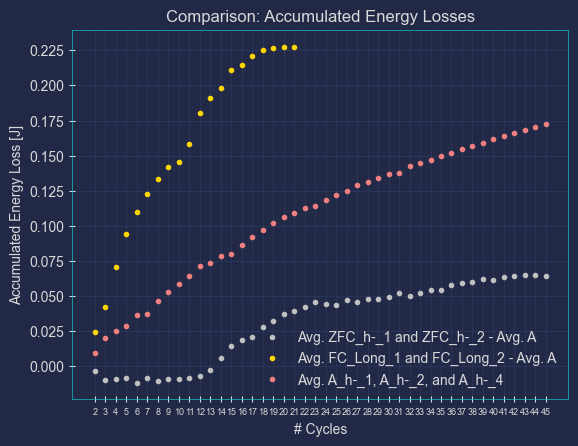

In [89]:
# Definition of the variables
x1        = range(2, l_min + 2)
x2        = range(2, l_min_2 + 2)
m1        = np.mean([ZFC_h_m_1_loss[:l_min], ZFC_h_m_2_loss[:l_min]], axis=0)
m2        = np.mean([FC_Long_1_loss[:l_min_2], FC_Long_2_loss[:l_min_2]], axis=0)
l_min_A   = min(len(A_h_m_1_U_loss), len(A_h_m_2_U_loss), len(A_h_m_4_U_loss))
a         = np.mean([A_h_m_1_U_loss[:l_min_A], A_h_m_2_U_loss[:l_min_A], A_h_m_4_U_loss[:l_min_A]], axis=0)
xa        = range(2, l_min_A + 2)
l_min_all = min(l_min, l_min_2, l_min_A)
# This is very "ugly", but, for now, it will serve.

# Plotting the data
plt.plot(x1[:l_min], m1[:l_min] - a [:l_min], '.', color='silver', label='Avg. ZFC_h-_1 and ZFC_h-_2 - Avg. A')
plt.plot(x2[:l_min_all], m2[:l_min_all] - a [:l_min_all], '.', color='gold', label='Avg. FC_Long_1 and FC_Long_2 - Avg. A')
plt.plot(xa[:l_min], a [:l_min], '.', color='lightcoral', label='Avg. A_h-_1, A_h-_2, and A_h-_4')

# Fix the xticks
plt.xticks(range(2, l_min + 2), fontsize=6.5)

# Set y-axis ticks at every 0.1 units
plt.yticks(np.arange(0, 0.25, 0.025))

plt.xlabel('# Cycles')
plt.ylabel('Accumulated Energy Loss [J]')
plt.title('Comparison: Accumulated Energy Losses')
plt.legend()